# Metrobus Reforma Control Sintético

## Introducción

En el 2015 la Secretaría de Movilidad (SEMOVI) de la CDMX anunció la intervención de la línea 7 del Metrobús sobre Paseo de la Reforma y Calzada de los Misterios argumentando que dichas vialidades “presentan alta concentración de oferta y demanda de transporte público de pasajeros, que conectan con importantes centros habitacionales del norte de la ciudad con las zonas comerciales y de servicios de la zona norte, centro y poniente de la capital” según información de la revista [Forbes México](https://www.forbes.com.mx/linea-7-del-metrobus-entre-la-movilidad-y-la-explotacion-comercial/). De acuerdo al mismo artículo, la SEMOVI afirmó que esta línea ahorraría hasta 160,000 viajes al día y no afectaría la vialidad en Reforma.

La línea 7, conocida como Metrobús Reforma, inció su construcción el 24 de enero del 2017 y se ignauguró el 5 marzo del 2018. De acuerdo con los datos de [Global BRT Data](https://brtdata.org/location/latin_america/mexico/mexico_city) para el 2018 la línea 7 ya movilizaba al rededor de 130,000 personas diarias, cumpliendo con una primera parte de su objetivo. Sin embargo, queda evaluar cómo afectó esta intervención a la vialidad en la zona. Este proyecto tiene como objetivo estimar el efecto del Metrobús Reforma en los tiempos de traslado entre las AGEBs dentro de su área de influencia. Para esto se utiliza la metodología de Control Sintético desarrolada por Alberto Abadie, Javier Gardeazabal, Alexis Diamond, Jens Hainmueller, entre otros, con el fin de estimar la trayectoria contrafactual de los tiempos de movilidad dentro de la zona afectada en caso de no haber sido intervenida. 

Utiliza datos abiertos del Gobierno de la Ciudad de Mpexico, del INEGI y de Uber Movement. Estos últimos proporcionan un estimado del tiempo promedio que toma trasladarse de una AGEB a otra en la CDMX del 2016 al 2020.

Esta libreta contiene el código para la obtención y procesamiento de los datos necesarios así como el análsiis, visualización, estimación del modelo y análisis de los resultados. 

## Setup

In [32]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import *
from INEGIpy import MarcoGeoestadistico
import json
import geopandas as gpd
from geopandas import GeoDataFrame
from shapely.geometry import Point
import requests
from sklearn.preprocessing import StandardScaler
from shapely import LineString
import folium
import unicodedata
import matplotlib.pyplot as plt
from pprint import pprint

### Inicialización de los datos

#### Movement Zones (AGEBs)

La data de Uber Movement se basa en AGEBs, los cuales renombra con su MOVEMENT_ID y DISPLAY_NAME pero mantiene las las claves de AGEBs definidas por el INEGI.

In [2]:
with open('mexico_city_agebs.json', 'r') as f:
    ageb_ids = json.loads(f.read())
    
ageb_ids = gpd.GeoDataFrame.from_features(ageb_ids)
ageb_ids.MOVEMENT_ID = ageb_ids.MOVEMENT_ID.astype(int)
ageb_ids.crs = 'EPSG:4326'
# ageb_ids = ageb_ids.to_crs('EPSG:6372')
ageb_ids.head()

,geometry,CVE_AGEB,CVE_MUN,CVE_LOC,CVE_ENT,MOVEMENT_ID,DISPLAY_NAME
0,"POLYGON ((-99.24182 19.68300, -99.24096 19.681...",1142,121,0,15,1,Movement Zone 1
1,"POLYGON ((-98.96833 19.29859, -98.96824 19.299...",1012,122,0,15,2,Movement Zone 2
2,"POLYGON ((-98.91891 19.68579, -98.91798 19.685...",0393,002,0,15,3,Movement Zone 3
3,"POLYGON ((-99.34220 19.55510, -99.34167 19.554...",003A,046,0,15,4,Movement Zone 4
4,"POLYGON ((-98.87485 19.18100, -98.87470 19.180...",0037,089,0,15,5,Movement Zone 5


#### Metrobús

In [18]:
# metrobus
mb = gpd.read_file('mb_shp')
mb = mb.drop_duplicates('CVE_EST')
mb.AÑO = mb.AÑO.fillna(2005).astype(int)
mb = mb.to_crs('EPSG:4326')
mb.head()

,SISTEMA,NOMBRE,LINEA,EST,CVE_EST,CVE_EOD17,TIPO,ALCALDIAS,AÑO,geometry
0,Metrobús,Terminal 1 - Aeropuerto,04,41,MB0441,NaN,NaN,Venustiano Carranza,2005,POINT Z (-99.08367 19.43531 0.00000)
1,Metrobús,Terminal 2 - Aeropuerto,04,42,MB0442,NaN,NaN,Venustiano Carranza,2005,POINT Z (-99.07725 19.42148 0.00000)
2,Metrobús,Delegación Cuauhtémoc,04,02,MB0402,11121,Intermedia,Cuauhtémoc,2012,POINT Z (-99.15242 19.44259 0.00000)
4,Metrobús,México Tenochtitlan,04,03,MB0403,NaN,Intermedia,Cuauhtémoc,2005,POINT Z (-99.15327 19.43903 0.00000)
6,Metrobús,Plaza de la República,04,18,MB0418,11142,Intermedia,Cuauhtémoc,2012,POINT Z (-99.15414 19.43680 0.00000)


#### Marco Geoestadístico

In [20]:
def remove_accents(input_str):
    nfkd_form = unicodedata.normalize('NFKD', input_str)
    return u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

cdmx_muns = MarcoGeoestadistico().Municipios(entidades='09')
vialidades = MarcoGeoestadistico().Vialidades(claves_concatenadas=cdmx_muns.cvegeo.tolist())
vialidades['name'] = vialidades.nomvial.str.lower().apply(remove_accents)
vialidades.head()

,geometry,cvegeo,cve_agee,cve_agem,cve_loc,cve_via,nomvial,tipovial,ambito,sentido,name
0,"MULTILINESTRING ((-99.13279 19.32841, -99.1327...",090030001,09,003,0001,03172,Ninguno,Cerrada,Urbana,Dos sentidos,ninguno
1,"MULTILINESTRING ((-99.13200 19.32450, -99.1309...",090030001,09,003,0001,03174,Retorno 55,Cerrada,Urbana,Dos sentidos,retorno 55
2,"MULTILINESTRING ((-99.12881 19.32444, -99.1287...",090030001,09,003,0001,04069,Ejido de San Francisco Culhuacán,Avenida,Urbana,Dos sentidos,ejido de san francisco culhuacan
3,"MULTILINESTRING ((-99.13402 19.32317, -99.1334...",090030001,09,003,0001,02617,Capitán de Fragata Pedro Sáinz De Baranda,Calle,Urbana,Dos sentidos,capitan de fragata pedro sainz de baranda
4,"MULTILINESTRING ((-99.13243 19.32247, -99.1321...",090030001,09,003,0001,02617,Capitán de Fragata Pedro Sáinz De Baranda,Calle,Urbana,Dos sentidos,capitan de fragata pedro sainz de baranda


#### Movement Data

Uber publicó data de movilidad entre AGEBs del 2016 al primer trimestre del 2020. Esta data tiene el tiempo promedio que toma llegar de AGEB 1 a AGEB 2. Esta data se procesó para obtener una serie de tiempo para cada AGEB con el tiempo promedio que toma llegar a las AGEBs colindantes. 

In [ ]:
movement = pd.read_csv('./weekdays_ageb_avg_trafic.csv')
movement.head()

,month,mean_travel_time,ageb,year
0,1,364.246667,1,2016
1,2,444.016667,1,2016
2,3,416.843333,1,2016
3,1,374.590000,2,2016
4,2,279.840000,2,2016


## Unidades de estudio

### Definición

La SEMOVI seleccionó el área de intervención de la línea 7 sobre Reforma y Calzada de los Misterios por ser vialidades importantes con alta demanda de transporte y que sirven para conectar diferentes zonas de la ciudad. Bajo estas consideraciones definimos la unidad de tratamiento como el grupo de AGEBs intersectadas por alguna estación de la ruta. A si mismo definimos una segunda área afectada como las AGEBs colindantes a las AGEBs directamente intervenidas. 

Una vez establecida la unidad de tratamiento definimos las unidades del grupo de donantes como aquellas que también pudieron ser intervenidas bajo estas mismas consideraciones. Para esto seleccionamos un conjunto de vialidades que compartan los criterios establecidos por la SEMOVI: debe ser una vialidad principal, de alta demanda y oferta de transporte y que conecte zonas alejadas de la ciudad. A si mismo, estas unidades no deben haber sido intervenidas durante el periodo de estudio. 

In [21]:
# de manera conceptual imaginamos las unidades de la siguiente forma:

class Unit:
    
    def __init__(self):
        self.name: str
        self.linea: GeoDataFrame
        self.intersected_agebs: GeoDataFrame
        self.affected_agebs: GeoDataFrame
        self.surrounding_agebs: GeoDataFrame
        
    def plot_influence_area(self):
        '''
        Plots the influence area of the defined unit.
        
        Returns:
            ax: matplotlib axis object.
            
        '''
        ax = self.surrounding_agebs.plot(color='grey', alpha=0.7, figsize=(8,8))
        self.affected_agebs.plot(alpha=0.8, ax=ax)
        self.intersected_agebs.plot(ax=ax, color='green', alpha=0.7)
        self.linea.plot(ax=ax, color='red')
        
        return ax
    
    def _get_area_stats(self):
        
        linea_m = self.linea.to_crs('EPSG:6372')
        intersected_agebs_m = self.intersected_agebs.to_crs('EPSG:6372')
        affected_agebs_m = self.affected_agebs.to_crs('EPSG:6372')
        
        self.lenght = linea_m.geometry.iloc[0].length / 1000
        self.intersected_area = intersected_agebs_m.area.sum() / 1000**2
        self.affected_area = affected_agebs_m.area.sum() / 1000**2
        
        self.stats_dict = {
            'Nombre': self.name,
            'Longitud (km)': self.lenght,
            'Área intersectada (km2)': self.intersected_area,
            'Área afectada (km2)': self.affected_area
        }

class TreatmentUnit(Unit):
    
    def __init__(self, linea: str):
        super().__init__()
        
        self.name: str = f'Línea {linea}'
        
        # estaciones
        self.estaciones = mb[mb.LINEA == linea].copy(deep=True)
        self._estaciones_multipoint = self.estaciones.dissolve(by='LINEA')
        
        # linea
        self.linea = self.estaciones.groupby('LINEA').geometry.apply(lambda x: LineString(x.tolist())).reset_index()
        self.linea.crs = 'EPSG:4326'
        
        # área de influencia
        self.intersected_agebs = ageb_ids[ageb_ids.geometry.intersects(self._estaciones_multipoint.iloc[0].geometry)]
        self._dissolved_intersected_agebs = self.intersected_agebs.dissolve(by='CVE_ENT').geometry.iloc[0]
        self.affected_agebs = ageb_ids[ageb_ids.geometry.intersects(self._dissolved_intersected_agebs)]
        self._dissolved_affected_agebs = self.affected_agebs.dissolve(by='CVE_ENT').geometry.iloc[0]
        self.surrounding_agebs = ageb_ids[ageb_ids.geometry.intersects(self._dissolved_intersected_agebs)]
        
        self._get_area_stats()
        
    # área de influencia plot
    def plot_influence_area(self):
        ax = super().plot_influence_area()
        self.estaciones.plot(color='yellow', ax=ax)
        
        return ax
    
class DonorUnit(Unit):
    
    def __init__(self, street_name: str):
        super().__init__()
        
        self._get_donor_area(street_name)
        self.name = self.linea.nomvial.iloc[0]
        
        self._get_area_stats()
        
        
    def _get_donor_area(self, name: str):
    
        avoid = ['Cerrada', 'Calle', 'Privada', 'Callejón', 'Retorno', 'Peatonal', 'Continuación']
        
        patch = ['02308', '00501', '00435']
        
        vialidad = vialidades[(vialidades.name.str.match(f'.*{name}.*')) & 
                            (~vialidades.tipovial.isin(avoid)) & 
                            (~vialidades.cve_via.isin(patch))].dissolve(by='cve_agee')
        
        if len(vialidad) == 0:
            raise ValueError('No se encontró la vialidad')
        
        intersected_agebs = ageb_ids[ageb_ids.geometry.intersects(vialidad.iloc[0].geometry)]
        dissolved_agebs_geom = intersected_agebs.dissolve(by='CVE_ENT').geometry.iloc[0]
        affected_agebs = ageb_ids[ageb_ids.geometry.intersects(dissolved_agebs_geom)]
        dissolved_aff_agebs = affected_agebs.dissolve(by='CVE_ENT').geometry.iloc[0]
        surrounding_agebs = ageb_ids[ageb_ids.geometry.intersects(dissolved_aff_agebs)]
        
        self.linea = vialidad
        self.intersected_agebs = intersected_agebs
        self.affected_agebs = affected_agebs
        self.surrounding_agebs = surrounding_agebs

### Unidad de tratamiento

Tenemos dos formas de definir el área intervenida: 
1. Tomar solamente las áreas con al menos una estación (el área verde) y obtener el tiempo de traslado entre las áreas colindantes limitado solamente a las AGEBs verdes. 
2. Tomar solamente las áreas con al menos una estación (el área verde) y obtener el tiempo de traslado entre todas las áreas colindantes, incluyendo las AGEBs azules.

Otras posibilidades son 
1. Incluir el tiempo promedio de traslado de las áreas azules a sus áreas colindantes limitado a las áreas azules y verdes. 
2. Incluir el tiempo promedio de traslado de las áreas azules a sus áreas colindantes incluyendo las áreas colindantes grises.
3. Hacer más de un CS: uno del área verde, otra verde + azul y tal vez uno de solo área azul.

Independientemente de cómo se defina el área intervenida necesitamos obtener áreas equiparables que sirvan para el grupo de donantes. Ya que la línea 7 se construyó sobre una de las avenidas más importantes y transitadas de la ciudad, la idea es buscar vialidades equiparables en su distancia, importancia y nivel de tránsito. Para esto aprovecho datos del Marco Geoestadístico del INEGI y datos de Tom Tom Traffic Index. Las áreas del grupo de donantes deben seguir la misma definición del área tratada que se elija arriba.

({'Longitud (km)': 14.404254076253078,
  'Área intersectada (km2)': 7.292864972764897,
  'Área afectada (km2)': 26.03087498953271},
 <Axes: >)

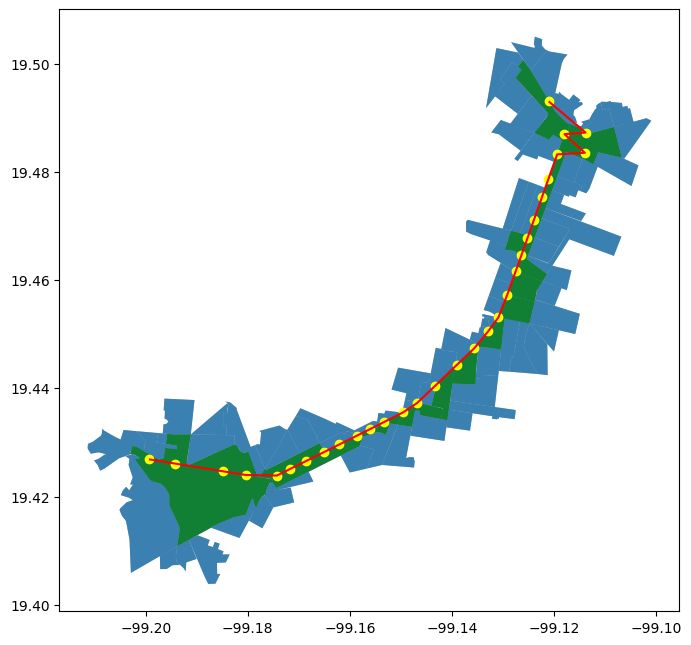

In [17]:
linea_7 = TreatmentUnit('07')

linea_7.stats_dict, linea_7.plot_influence_area()

### Unidades del grupo de donantes

<Axes: >

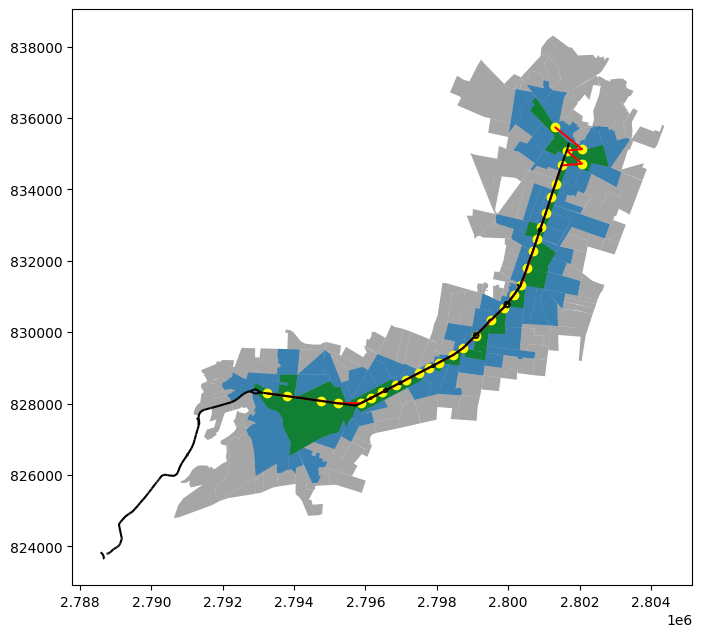

In [ ]:
# Avenidas sobre las que cruza la línea 7
ax = linea_7.plot_influence_area()
vialidades[vialidades.name.str.match('paseo de la reforma')].dissolve(by='nomvial').plot(ax=ax, color='black')
vialidades[vialidades.name.str.match('calzada de los misterios')].dissolve(by='nomvial').plot(ax=ax, color='black')

De la misma manera que la SEMOVI eligió el área de intervención, elegimos vialidades que cumplan con los mismos criterios que Reforma como unidades del grupo de donantes.

De acuerdo con el índice de tráfico 2017 que publica Tom Tom, las avenidas con mayor tránsito a parte de Reforma son:
* Viaducto Río de la Piedad
* Avenida Constituyentes
* Viaducto Miguel Alemán
* Río Mississipi y Calzada Melchor Ocampo
* Avenida 608
* Calzada de Tlalpan
* Av. Acueducto y Circuito Joaquín Clausell
* Calzada Chabacano 
* Avenida Doctor Ignacio Morones Prieto y Avenida Cuauhtémoc

Agrego personalmente:
* Periférico Sur
* Insurgentes Sur e Insurgentes Norte si es posible (intervención del metrobús previa en 2005 - 2008)
* por verse



In [25]:
donor_streets = [
    'rio de la piedad', 
    'constituyentes', 
    'miguel aleman',
    'calzada de tlalpan',
    'adolfo ruiz cortines',
    'patriotismo',
    'division del norte',
    'rio consulado',
    'insurgentes sur',
    'insurgentes norte',
    ]

donor_units = [DonorUnit(street) for street in donor_streets]

{'Longitud (km)': 6.385645147540718,
 'Nombre': 'Río de la Piedad',
 'Área afectada (km2)': 16.492539607888947,
 'Área intersectada (km2)': 7.826930141251778}


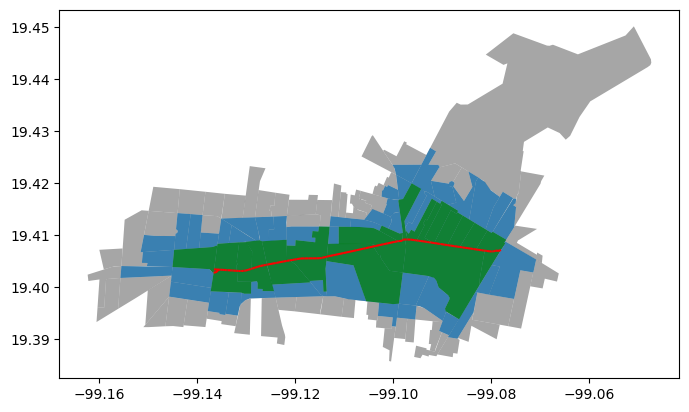

{'Longitud (km)': 6.965294623698295,
 'Nombre': 'Constituyentes',
 'Área afectada (km2)': 32.508005001373945,
 'Área intersectada (km2)': 14.905546762041125}


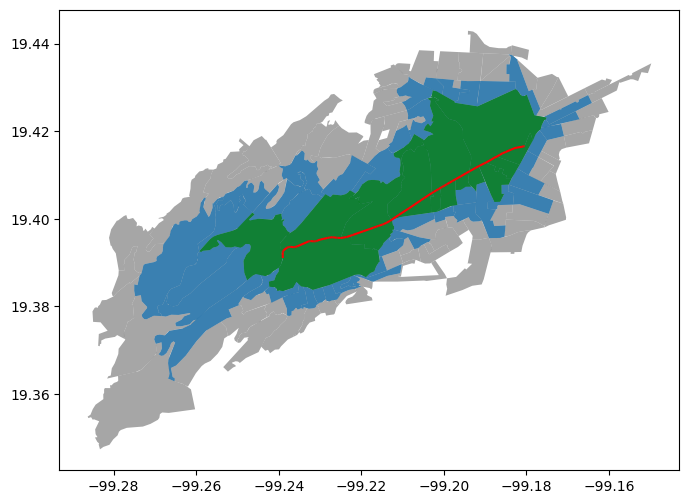

{'Longitud (km)': 6.551733807020972,
 'Nombre': 'Presidente Miguel Alemán',
 'Área afectada (km2)': 16.83384409193847,
 'Área intersectada (km2)': 5.552222065558179}


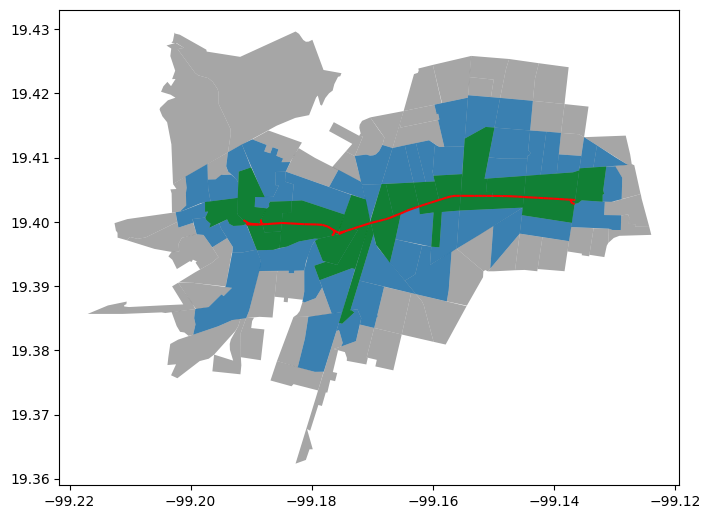

{'Longitud (km)': 16.580177987458548,
 'Nombre': 'Calzada De Tlalpan',
 'Área afectada (km2)': 44.90329594121704,
 'Área intersectada (km2)': 16.660289629924556}


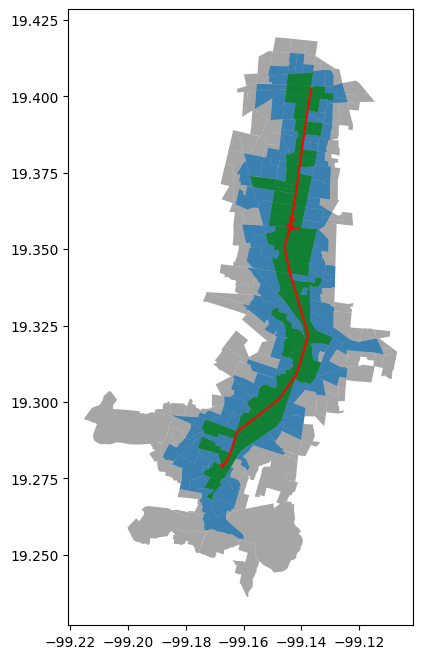

{'Longitud (km)': 18.895932594616564,
 'Nombre': 'Boulevard Adolfo Ruíz Cortines',
 'Área afectada (km2)': 79.60874677619147,
 'Área intersectada (km2)': 23.763328904482012}


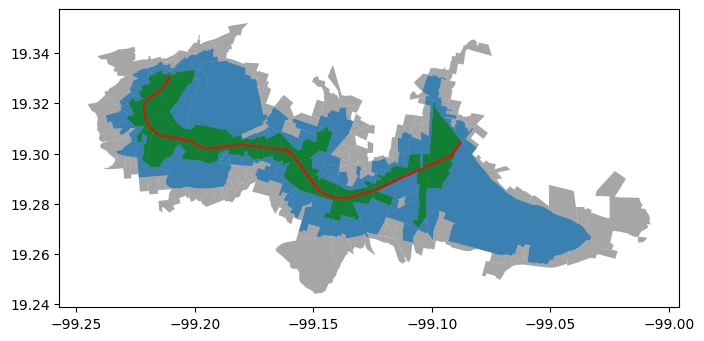

{'Longitud (km)': 4.836676374354364,
 'Nombre': 'Interior (Diagonal Patriotismo)',
 'Área afectada (km2)': 9.841579321002609,
 'Área intersectada (km2)': 3.6580923605858566}


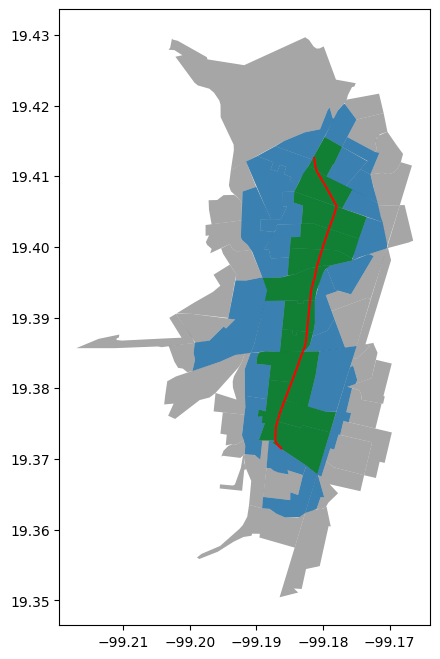

{'Longitud (km)': 17.207008138626055,
 'Nombre': 'División del Norte',
 'Área afectada (km2)': 49.542125252318975,
 'Área intersectada (km2)': 18.683629237826025}


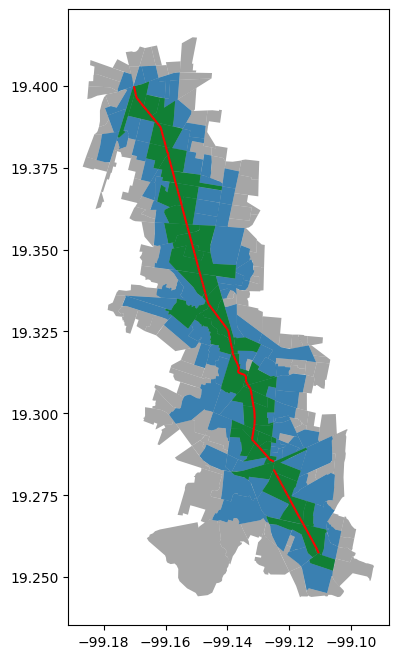

{'Longitud (km)': 8.957172946657801,
 'Nombre': 'Interior (Avenida Río Consulado)',
 'Área afectada (km2)': 25.12867343704564,
 'Área intersectada (km2)': 8.856842283321184}


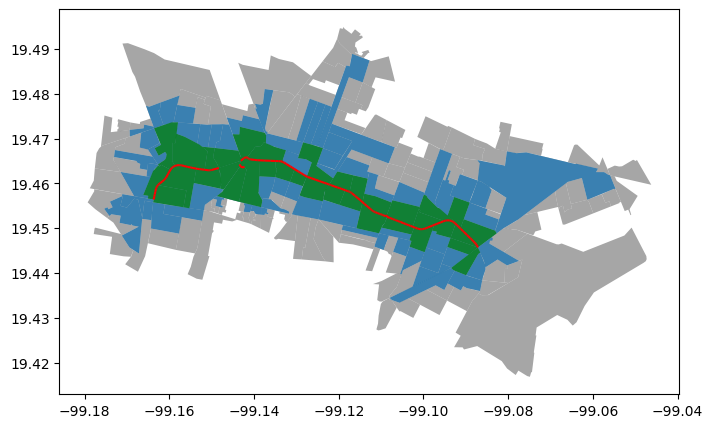

{'Longitud (km)': 19.506479447022194,
 'Nombre': 'Insurgentes Sur',
 'Área afectada (km2)': 62.850751140771074,
 'Área intersectada (km2)': 28.41919888859678}


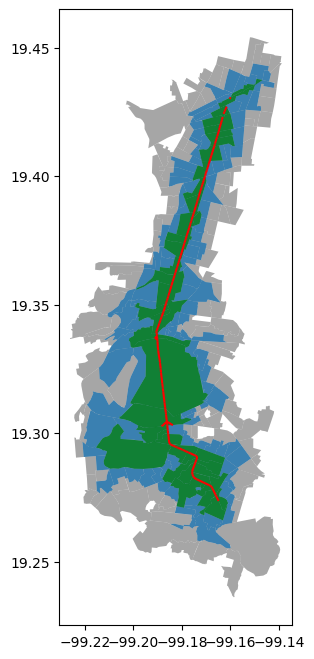

{'Longitud (km)': 16.949992809380046,
 'Nombre': 'Insurgentes Norte',
 'Área afectada (km2)': 24.49115132596065,
 'Área intersectada (km2)': 10.249012924717999}


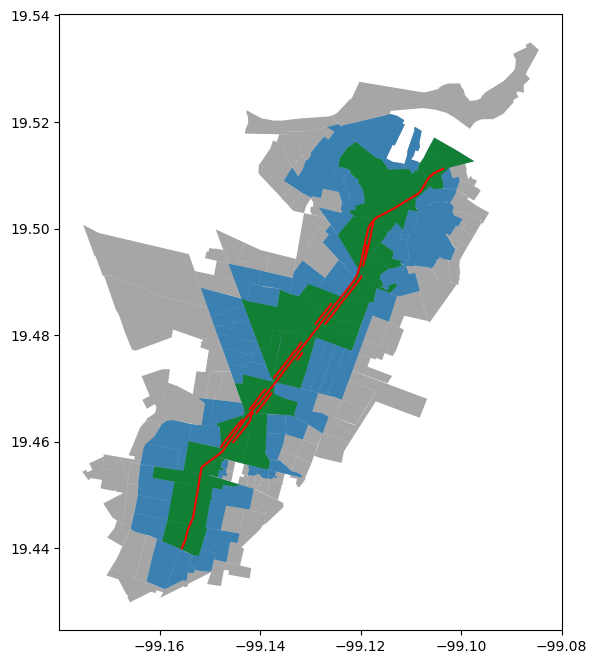

In [33]:
for donor_unit in donor_units:
    pprint(donor_unit.stats_dict)
    ax = donor_unit.plot_influence_area()
    plt.show()

### Covariables